# Table of Contents
* [Healthy Ride](#Healthy-Ride)
	* [Rides from 2016](#Rides-from-2016)
	* [Stations](#Stations)
	* [cleaning](#cleaning)
	* [Ride difficulty](#Ride-difficulty)
		* [elevation](#elevation)
		* [distance](#distance)
		* [grade](#grade)
		* [outliers](#outliers)
	* [Google Distance Matrix](#Google-Distance-Matrix)
* [Datetime](#Datetime)


# Healthy Ride

## Rides from 2016

In [1]:
import numpy as np
import pandas as pd
import googlemaps
from my_secrets.keys import google_dist, google_elev, google_gmap
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 5

In [2]:
dfs = []
for q in 1,2,3,4:
    df = pd.read_csv('2016-Q{0}/HealthyRide Rentals 2016 Q{0}.csv'.format(q), encoding='iso-8859-1')
    dfs.append(df)

rides = pd.concat(dfs, ignore_index=True)
rides

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype
0,15335599,1/1/2016 1:44,1/1/2016 2:01,70294,1068,1026,Penn Ave & S Whitfield St,1032,Walnut St & College St,NaN
1,15335629,1/1/2016 2:39,1/1/2016 2:53,70360,892,1029,Alder St & S Highland Ave,1021,Taylor St & Liberty Ave,NaN
...,...,...,...,...,...,...,...,...,...,...
76417,25722578,12/31/2016 16:24,12/31/2016 16:45,70116,1293,1017,21st St & Penn Ave,1015,Federal St & E North Ave,NaN
76418,25723077,12/31/2016 21:09,12/31/2016 21:46,70418,2222,1011,Fort Duquesne Blvd & 7th St,1011,Fort Duquesne Blvd & 7th St,NaN


## Stations

Positions of each station are stored separately.

In [3]:
stations2016 = pd.read_csv('2016-Q1/HealthyRideStations2016.csv',encoding='iso-8859-1', index_col=0).sort_index()
stations2016

,StationName,RackQnty,Latitude,Longitude
StationNum,,,,
1000,Liberty & Stanwix,16,40.441326,-80.004679
1001,Forbes Ave & Market Sq,19,40.440877,-80.003080
...,...,...,...,...
1048,S 18th St & Sidney St,16,40.429338,-79.980684
1049,S 12th St & E Carson St,19,40.428553,-79.986369


Let's grab the 2017 stations as well.

In [4]:
stations2017 = pd.read_csv('2017-Q1/HealthyRideStations2017.csv',encoding='iso-8859-1', index_col=0).sort_index()
stations2017.columns = stations2016.columns

There are two new stations in 2017.

In [5]:
all_stations = stations2016.join(stations2017, how='outer', lsuffix='_2016', rsuffix='_2017')
all_stations.loc[all_stations.isnull().any(axis='columns')]

,StationName_2016,RackQnty_2016,Latitude_2016,Longitude_2016,StationName_2017,RackQnty_2017,Latitude_2017,Longitude_2017
1050,NaN,NaN,NaN,NaN,Healthy Ride Hub,2,40.461817,-79.968002
1061,NaN,NaN,NaN,NaN,33rd St and Penn Ave,2,40.462026,-79.968114


We'll use the 2017 stations from now on.

In [6]:
stations = stations2017

## cleaning

The rides file has more station IDs than are listed in the stations file.

In [7]:
missing_stations = set()
for col in 'From station id', 'To station id':
    extra = ~rides[col].isin(stations.index)
    m = rides.loc[extra, col].drop_duplicates()
    missing_stations.update(m)
missing_stations

{1060}

Let's go get its name.

In [8]:
rides.loc[rides['From station id'].isin(missing_stations), 'From station name'].drop_duplicates()

46569    Open Streets West End
Name: From station name, dtype: object

Open Streets West End looks like a [temporary station](http://openstreetspgh.org/schedule-july-2016/#WABASH). Let's got find it.

In [9]:
c_map = googlemaps.Client(key=google_gmap)

In [10]:
wabash_and_main = c_map.geocode('Wabash and Main St. West End Pittsburgh, PA')[0]['geometry']['location']
wabash_and_main

{'lat': 40.4409099, 'lng': -80.0348104}

In [11]:
new_station = {
    'StationName':'Open Streets West End',
    'RackQnty':np.nan,
    'Latitude':wabash_and_main['lat'],
    'Longitude':wabash_and_main['lng']
}

stations.loc[1060] = new_station

In [12]:
stations

,StationName,RackQnty,Latitude,Longitude
Station #,,,,
1000,Liberty Ave & Stanwix St,16.0,40.441326,-80.004679
1001,Forbes Ave & Market Square,19.0,40.440877,-80.003080
...,...,...,...,...
1061,33rd St and Penn Ave,2.0,40.462026,-79.968114
1060,Open Streets West End,NaN,40.440910,-80.034810


## Ride difficulty

We'll compute the following quantities
* ride distance
* elevation change
* deviation from expected duration

### elevation

In [13]:
c_elev = googlemaps.Client(key=google_elev)

In [14]:
pos = stations[['Latitude','Longitude']].values.tolist()
elev = [d['elevation'] for d in c_elev.elevation(pos)]
stations['elevation'] = elev

In [15]:
def elevation_change(row, stations=stations):
    start = row['From station id']
    stop = row['To station id']
    
    e1 = stations.loc[start, 'elevation']
    e2 = stations.loc[stop, 'elevation']
    return e2 - e1

In [16]:
rides['elevation_change'] = 0.0

one_way = rides['From station id'] != rides['To station id']
rides.loc[one_way,'elevation_change'] = rides.loc[one_way].apply(elevation_change, axis='columns')

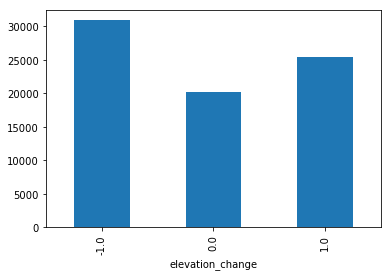

In [17]:
rides.groupby(np.sign(rides['elevation_change']))['Trip id'].count().plot.bar()

### distance

[Read this](https://gis.stackexchange.com/questions/84885/whats-the-difference-between-vincenty-and-great-circle-distance-calculations) for a discussion of distance algorithms.

In [18]:
from geopy.distance import vincenty, great_circle

In [19]:
def distance(row, dfunc=vincenty, stations=stations):
    start = row['From station id']
    stop = row['To station id']
    
    p1 = stations.loc[start, ['Latitude','Longitude']].tolist()
    p2 = stations.loc[stop, ['Latitude','Longitude']].tolist()
    
    d = dfunc(p1, p2)
    
    return d.miles

In [20]:
%%time
d_circle = rides.apply(distance, dfunc=great_circle, axis='columns')

CPU times: user 1min 25s, sys: 131 ms, total: 1min 25s
Wall time: 1min 25s


I'll blame Pandas for most of the slowdown. I'd prefer to have a NumPy-based or C-level function.

In [21]:
%%time
d_vincenty = rides.apply(distance, dfunc=vincenty, axis='columns')

CPU times: user 1min 26s, sys: 118 ms, total: 1min 26s
Wall time: 1min 26s


Since we can assume that the vincenty distance is more accurate, great circle distances are about 0.5 mile off on average. 

That's rather large for this use since there can be many bike stations within 0.5 mile.

In [22]:
np.sqrt( ((d_circle - d_vincenty)**2).sum()  )

0.53558351298622842

For fun, let's use [Numba](http://numba.pydata.org/) to write a fast haversine implementation.

Numba will compile the function to optimized C code (using the LLVM compiler), and it understands NumPy arrays natively.

In [24]:
from geopy.distance import EARTH_RADIUS
from scipy.constants import mile
import numba

@numba.guvectorize(['(float64[:,:], float64[:,:], float64[:])'], '(n,m),(n,m)->(n)', nopython=True)
def haversine(origin, destination, output):
    '''the haversine distance in miles'''
    assert origin.shape[0] == destination.shape[0]
    
    # earth radius in miles
    constant = EARTH_RADIUS * 1000/mile * 2
    p = np.pi / 180
    
    n = origin.shape[0]
    for i in range(n):
        lat1 = origin[i,0]
        lon1 = origin[i,1]
        lat2 = destination[i,0]
        lon2 = destination[i,1]
    
    
        a = 0.5 - np.cos((lat2 - lat1) * p) / 2  \
           + np.cos(lat1 * p) * np.cos(lat2 * p) \
           * (1 - np.cos((lon2 - lon1) * p )) / 2
        output[i] = constant * np.arcsin(np.sqrt(a))

In [25]:
%%time
p0 = rides.join(stations, on='From station id')[['Latitude','Longitude']].values
p1 = rides.join(stations, on='To station id')[['Latitude', 'Longitude']].values
d_haversine = np.empty(shape=p0.shape[0], dtype=np.float64)

haversine(p0, p1, d_haversine)

CPU times: user 39.9 ms, sys: 11.9 ms, total: 51.8 ms
Wall time: 52.2 ms


This function gives the same results as the slow `great_cirle()` from `geopy`.

In [26]:
np.allclose(d_circle, d_haversine)

True

### grade

Ride difficulty will be defined as [percent grade](https://en.wikipedia.org/wiki/Grade_(slope)), which is dimensionless.

Bikes returned to the same station have `NaN` grade.

In [27]:
rides['distance (miles)'] = d_vincenty

In [28]:
rides['grade'] = rides['elevation_change'] / (rides['distance (miles)']*5280) * 100

In [29]:
with pd.option_context('display.max_rows',15):
    print(rides['grade'].describe())

count    56245.000000
mean        -0.053069
std          0.322528
min         -2.672255
25%         -0.150023
50%         -0.017170
75%          0.067557
max          2.672255
Name: grade, dtype: float64


Fit a simple normal distribution.

In [30]:
mu = rides['grade'].mean()
sigma = rides['grade'].std()
from scipy.stats import norm
rv = norm(loc=mu, scale=sigma)

Rides taken are centered near zero-grade trips. All rides, even those that are returned to the same station are included.

They almost follow a normal distribution.

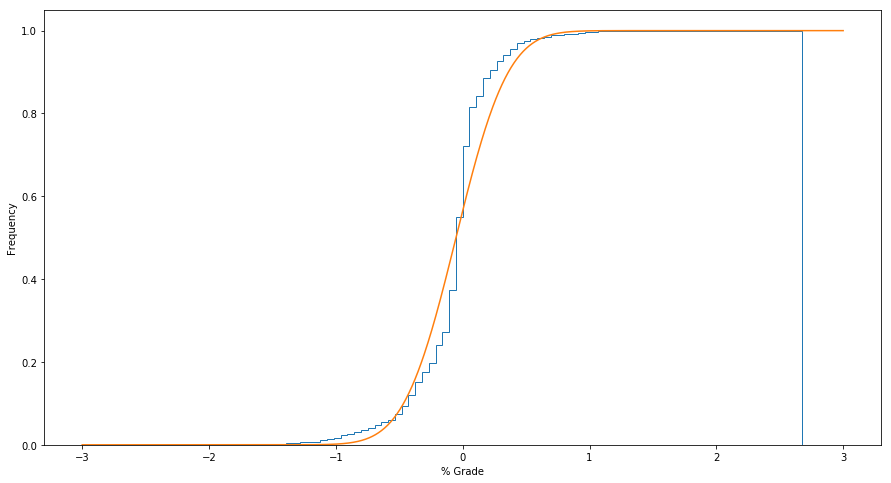

In [31]:
ax = rides['grade'].plot.hist(normed=True, cumulative=True, histtype='step', bins=100, figsize=(15,8))

x = np.linspace(-3, 3, 1000)
ax.plot(x, rv.cdf(x))

plt.xlabel('% Grade')

In [32]:
by_ride = rides.loc[one_way].groupby(['From station id','To station id'])

popularity = by_ride['Trip id'].count()
popularity.name = 'rides'
difficulty = by_ride['grade'].first()

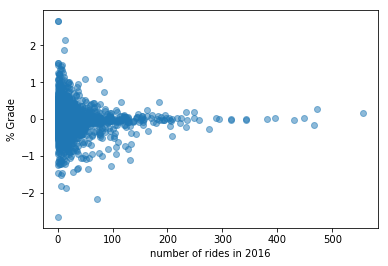

In [33]:
plt.scatter(popularity, difficulty, alpha=0.5)
plt.xlabel('number of rides in 2016')
plt.ylabel('% Grade')

### outliers

In [34]:
from sklearn.ensemble import IsolationForest

In [35]:
X = pd.concat([popularity,difficulty], axis='columns')

In [36]:
iso = IsolationForest(contamination=0.02)
iso.fit(X)
labels = iso.predict(X)
(labels==-1).sum()

44

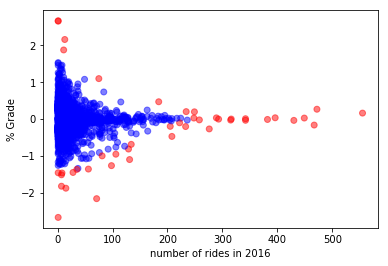

In [37]:
colors = np.where(labels==-1, 'red', 'blue')

plt.scatter(popularity, difficulty, alpha=0.5, c=colors)
plt.xlabel('number of rides in 2016')
plt.ylabel('% Grade')

In [38]:
outliers = (
    X.loc[labels==-1]
    .reset_index()
    .join(stations['StationName'], on='From station id')
    .join(stations['StationName'], on='To station id', lsuffix='_from', rsuffix='_to')
)    

These are the outlier trips. They fall into two categories
1. Extremely popular rides
2. Rides with extreme grade

In [39]:
pd.options.display.max_rows = 100
outliers.sort_values(['grade','rides'])

,From station id,To station id,rides,grade,StationName_from,StationName_to
39,1042,1016,1,-2.672255,Centre Ave & Kirkpatrick St,17th St & Penn Ave
19,1020,1019,71,-2.162540,42nd St & Penn Ave (Children's Hospital),42nd St & Butler St
18,1020,1018,15,-1.878647,42nd St & Penn Ave (Children's Hospital),37th St & Butler St
37,1042,1009,7,-1.824594,Centre Ave & Kirkpatrick St,12th St & Penn Ave
38,1042,1010,7,-1.514441,Centre Ave & Kirkpatrick St,10th St & Penn Ave (David L. Lawrence Conventi...
7,1008,1009,8,-1.464843,Centre Ave & PPG Paints Arena,12th St & Penn Ave
21,1020,1061,1,-1.459064,42nd St & Penn Ave (Children's Hospital),33rd St and Penn Ave
20,1020,1050,28,-1.450973,42nd St & Penn Ave (Children's Hospital),Healthy Ride Hub
22,1021,1018,35,-1.367609,Taylor St & Liberty Ave,37th St & Butler St
23,1021,1019,56,-1.358789,Taylor St & Liberty Ave,42nd St & Butler St


## Google Distance Matrix

Let's use the Google Maps Distance Matrix to get *actual* distance along the journey.

This assumes that the rider kept to Google Map's recommended route.

In [40]:
c_dist = googlemaps.Client(key=google_dist)

In [41]:
origin = (
    rides[['From station id']]
    .merge(stations[['Latitude','Longitude']], left_on='From station id', right_index=True)
)

destination = (
    rides[['To station id']]
    .merge(stations[['Latitude','Longitude']], left_on='To station id', right_index=True)
)

unique_pairs = origin.join(destination, lsuffix='_origin', rsuffix='_dest').drop_duplicates()

In [42]:
unique_pairs.head()

,From station id,Latitude_origin,Longitude_origin,To station id,Latitude_dest,Longitude_dest
0,1026,40.461603,-79.925624,1032,40.453382,-79.927310
298,1026,40.461603,-79.925624,1037,40.441032,-79.948042
333,1026,40.461603,-79.925624,1033,40.451770,-79.932324
519,1026,40.461603,-79.925624,1024,40.458714,-79.933483
988,1026,40.461603,-79.925624,1020,40.465893,-79.954417


In [43]:
def g_dist_time(df):
    origins = df[['Latitude_origin','Longitude_origin']].to_frame().T.to_records(index=False)
    destinations = df[['Latitude_dest','Longitude_dest']].to_frame().T.to_records(index=False)
    
    json = c_dist.distance_matrix(origins, destinations, units='imperial', mode='bicycling')
    
    rows = [r['elements'][0] for r in json['rows']]
    # units don't matter; ['distance']['value'] is _always_ in meters
    values = {'distance (meters)':rows[0]['distance']['value'],
                  'time':pd.to_timedelta(rows[0]['duration']['value'], unit='s')}
    return pd.Series(values)

In order to comply with the [Distance Matrix API usage limits](https://developers.google.com/maps/documentation/distance-matrix/usage-limits) let's run the apply every 10 rows and wait a few seconds in between. 

In [54]:
import time

results = []
for chunk in np.array_split(unique_pairs, 200)[10:]:
    time.sleep(10)
    result = chunk.apply(g_dist_time, axis='columns')
    results.append(result)

In [58]:
gmap = pd.concat(results)
gmap.to_csv('distances.csv')
gmap.head()

,distance (meters),time
0,1068,00:03:47
298,3735,00:14:12
333,1686,00:06:26
519,954,00:03:33
988,2543,00:10:16


In [63]:
gmap_pairs = unique_pairs.join(gmap).rename(columns={'distance (meters)':'Gdistance (meters)'})

In [68]:
rides_complete = rides.merge(gmap_pairs)
rides_complete.to_csv('rides2016.csv', index=False)

# Datetime

In [ ]:
for c in 'Starttime','Stoptime':
    rides_complete[c] = pd.to_datetime(rides_complete[c])

The tripduration is claimed to be in seconds, but many of these just look wrong.

In [87]:
rides_complete['Tripduration'] = pd.to_timedelta(rides_complete['Tripduration'], unit='s')

The starttime should not be after the stoptime!

In [88]:
wierd = rides_complete['Starttime'] > rides_complete['Stoptime']
rides_complete.loc[wierd]

,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,elevation_change,distance (miles),grade,Latitude_origin,Longitude_origin,Latitude_dest,Longitude_dest,Gdistance (meters),time
6565,25067606,2016-10-29 20:57:00,2016-10-29 20:06:00,70171,09:11:00,1045,S 27th St & Sidney St. (Southside Works),1048,S 18th St & Sidney St,NaN,0.899063,0.774742,0.021979,40.427899,-79.966112,40.429338,-79.980684,1498,00:04:44
6566,25067607,2016-10-29 20:57:00,2016-10-29 20:14:00,70307,17:09:00,1045,S 27th St & Sidney St. (Southside Works),1048,S 18th St & Sidney St,NaN,0.899063,0.774742,0.021979,40.427899,-79.966112,40.429338,-79.980684,1498,00:04:44


According to Google the longest ride between any two stations is 45 minutes.

In [95]:
rides_complete['time'].describe()

count                     76419
mean     0 days 00:08:00.625276
std      0 days 00:07:38.314351
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:06:31
75%             0 days 00:12:13
max             0 days 00:45:19
Name: time, dtype: object

Let's ignore rides longer than 2 hours. It's likely that the bike sat stationary somewhere along the way.

In [107]:
diff = (rides_complete['Stoptime'] - rides_complete['Starttime'])

extreme = diff > pd.to_timedelta(2, unit='h')
extreme.sum()

5550

In [108]:
one_way = rides_complete['From station id'] != rides_complete['To station id']

clean = ~wierd & ~extreme & one_way

In [109]:
diff.loc[clean].describe()

count                     53609
mean     0 days 00:23:02.301106
std      0 days 00:21:35.451164
min             0 days 00:01:00
25%             0 days 00:09:00
50%             0 days 00:16:00
75%             0 days 00:28:00
max             0 days 02:00:00
dtype: object

In [141]:
deviation = (diff.loc[clean] - rides_complete.loc[clean, 'time']).dt.total_seconds() / 60
rides_complete['time deviation (min)'] = deviation

In [142]:
deviation.describe()

count    53609.000000
mean        12.173457
std         20.730310
min        -23.033333
25%          0.733333
50%          3.766667
75%         13.350000
max        119.066667
dtype: float64

In [143]:
times = pd.cut(deviation, bins=[-30, 0, 10, 60, 120], labels=['early', 'on_time', 'late', 'very_late'])

A majority of our rides are on time!

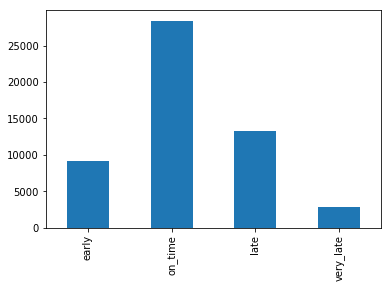

In [147]:
by_time = rides_complete.loc[clean].groupby(times)
by_time['Trip id'].count().plot.bar()

There may not be much correlation between the deviation from the Google Map time and the grade.

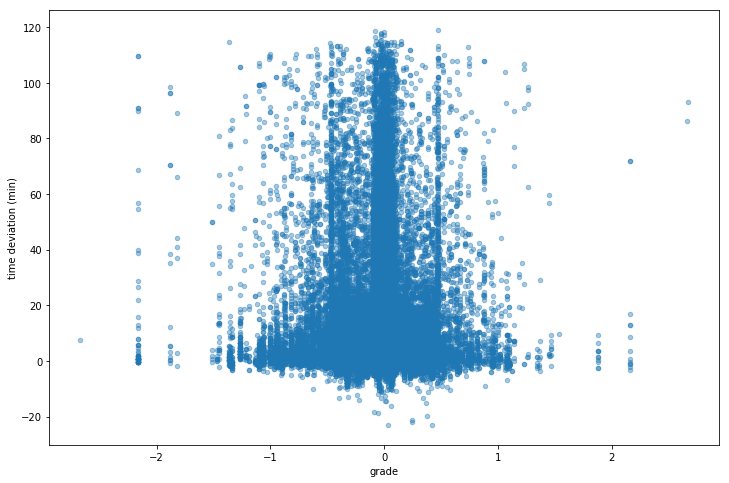

In [164]:
rides_complete.plot.scatter(x='grade', y='time deviation (min)', figsize=(12,8), alpha=0.4)

Here are some of the longest rides.

In [159]:
large_deviation = (
   rides_complete.loc[clean]
  .groupby(['From station name','To station name'])['time deviation (min)']
  .median()
  .nlargest(15)
)                   

large_deviation = large_deviation.reset_index().merge(rides_complete[['From station name','To station name','grade']])
large_deviation.drop_duplicates(subset=['From station name','To station name'])

,From station name,To station name,time deviation (min),grade
0,Stevenson St & Forbes Ave,Centre Ave & PPG Paints Arena,104.850000,1.226560
3,Liberty Ave & Baum Blvd,Healthy Ride Hub,103.083333,-0.591066
4,Third Ave & Wood St,Ross St & Sixth Ave (Steel Plaza T Station),102.966667,0.744398
11,Open Streets West End,Ridge Ave & Brighton Rd (CCAC),100.350000,0.175440
12,Schenley Dr at Schenley Plaza (Carnegie Librar...,37th St & Butler St,95.183333,-0.426116
14,S Negley Ave & Baum Blvd,S 25th St & E Carson St,93.650000,-0.295472
15,17th St & Penn Ave,Centre Ave & Kirkpatrick St,93.133333,2.672255
16,Isabella St & Federal St (PNC Park),Centre Ave & Kirkpatrick St,92.650000,1.073001
18,Centre Ave & Kirkpatrick St,S 22nd St & E Carson St,91.666667,-1.213578
21,Forbes Ave & Grant St,Third Ave & Wood St,90.866667,-0.837623
